# ALM 1 Ingest
This notebook ingests the data into the `tutorial_alm1_ingest` database.

The dataset is described here: https://crcns.org/data-sets/motor-cortex/alm-1/about-alm-1

The data structure is described here: https://crcns.org/files/data/alm-1/crcns_alm-1_data_description.pdf

The original paper is https://www.nature.com/nature/journal/v519/n7541/full/nature14178.html

In [1]:
import datajoint as dj
import scipy.io as scio
import os
from IPython.core.debugger import set_trace

In [2]:
dj.config['database.host'] = 'mesoscale-activity.datajoint.io'
dj.config['database.user'] = 'dimitri'

In [3]:
schema = dj.schema('tutorial_alm1_ingest', locals())

Connecting dimitri@mesoscale-activity.datajoint.io:3306


# Import Animal and Session data

In [4]:
import os
import scipy.io as scio

meta_data_path = 'data/ALM-1/meta_data'

@schema
class SessionDirectory(dj.Lookup):

    definition = """
    session_file : varchar(255)    
    """
    
    contents = [[os.path.join(meta_data_path, f)]
                for f in os.listdir(meta_data_path) if f.endswith('.mat')]


In [5]:
@schema
class Animal(dj.Imported):
    definition = """
    animal :  int  # animal id 
    ---
    species  : varchar(255)
    date_of_birth : date
    """
    
    class GeneModification(dj.Part):
        definition = """
        -> Animal
        gene_modification : varchar(30)
        """
        
    class Strain(dj.Part):
        definition = """
        -> Animal
        strain  : varchar(30)
        """


@schema
class Session(dj.Imported):
    definition = """
    -> Animal
    session : tinyint 
    ---
    session_date   :  date
    session_suffix :  char(1) 
    -> SessionDirectory
    UNIQUE INDEX(animal, session_date, session_suffix)
    """

    @property
    def key_source(self):
        return SessionDirectory()
    
    def _make_tuples(self, key):        
        r = scio.loadmat(key['session_file'], 
                         struct_as_record=False, squeeze_me=True)['meta_data']
        # extract animalID
        if not isinstance(r.animalID, str):
            r.animalID = r.animalID[0]   # handles errors in data
        animal = int(r.animalID[3:])  
        key['animal'] = animal
        
        # insert animal if first time
        if not (Animal() & key):
            tup = dict(
                animal=animal,
                species=r.species, 
                date_of_birth = "{year}-{month}-{day}".format(
                    year=r.dateOfBirth[0:4], 
                    month=r.dateOfBirth[4:6], 
                    day=r.dateOfBirth[6:8]))
            Animal().insert1(tup)
            if isinstance(r.animalGeneModification, str):
                r.animalGeneModification = [r.animalGeneModification]
            Animal.GeneModification().insert(
                dict(animal=animal, gene_modification=m) for m in r.animalGeneModification)
            if isinstance(r.animalStrain, str):
                r.animalStrain = [r.animalStrain]
            Animal.Strain().insert(
                dict(animal=animal, strain=m) for m in r.animalStrain)

        tup = key
        tup['session'] = len(Session() & dict(animal=animal))+1  
        tup['session_date'] = "{year}-{month}-{day}".format(
                year=r.dateOfExperiment[0:4], 
                month=r.dateOfExperiment[4:6], 
                day=r.dateOfExperiment[6:8])
        tup['session_suffix'] = os.path.basename(key['session_file']).split('_')[3][8]
        self.insert1(tup)        

In [6]:
Session().populate()

In [7]:
Session()

animal animal id,session,session_date,session_suffix,session_file
210861,1,2013-07-01,.,data/ALM-1/meta_data/meta_data_ANM210861_20130701.mat
210861,2,2013-07-02,.,data/ALM-1/meta_data/meta_data_ANM210861_20130702.mat
210861,3,2013-07-03,.,data/ALM-1/meta_data/meta_data_ANM210861_20130703.mat
210862,1,2013-06-26,.,data/ALM-1/meta_data/meta_data_ANM210862_20130626.mat
210862,2,2013-06-27,.,data/ALM-1/meta_data/meta_data_ANM210862_20130627.mat
210862,3,2013-06-28,.,data/ALM-1/meta_data/meta_data_ANM210862_20130628.mat
210863,1,2013-06-26,.,data/ALM-1/meta_data/meta_data_ANM210863_20130626.mat


In [8]:
@schema
class PhotoStim(dj.Imported):
    definition = """
    -> Session
    ---
    wavelength : decimal(4,1)
    """
    
    class Location(dj.Part):
        definition = """
        -> PhotoStim
        photostim_loc  : tinyint 
        ---
        identification_method : varchar(30)
        stimulation_method : varchar(30)
        area  : varchar(30)
        photostim_x   :  decimal(5,3)    # mm
        photostim_y   :  decimal(5,3)    # mm 
        photostim_z   :  decimal(5,3)    # mm
        """
        
    def _make_tuples(self, key):
        file = (Session() & key).fetch1('session_file')
        q = scio.loadmat(file, struct_as_record=False, squeeze_me=True)['meta_data'].photostim
        self.insert1(dict(key, wavelength=q.photostimWavelength))
        self.Location().insert(
            dict(key, 
                 photostim_loc=i, 
                 area=tup[0], 
                 identification_method=tup[1],
                 stimulation_method=tup[2],
                 photostim_x=tup[3][0],
                 photostim_y=tup[3][1],
                 photostim_z=tup[3][2])
            for i, tup in enumerate(
                zip(q.photostimLocation, 
                    q.identificationMethod, 
                    q.stimulationMethod, 
                    q.photostimCoordinates)))
            

In [13]:
PhotoStim().populate(suppress_errors=True, reserve_jobs=True)

[]

In [17]:
dj.U('stimulation_method', 'identification_method') & PhotoStim().Location()

stimulation_method,identification_method
optical fiber,histology
craniotomy,stereotaxic coordinate
clear skull,stereotaxic coordinate


In [18]:
key = PhotoStim().key_source.fetch(dj.key)[3]
file = (Session() & key).fetch1('session_file')
r = scio.loadmat(file, struct_as_record=False, squeeze_me=True)['meta_data']

In [19]:
r.behavior.task_keyword

array(['detection', 'discrimination', 'lick Left lick Right', 'delay',
       'somatosensory', 'motor', 'response', 'reward'], dtype=object)

In [20]:
@schema
class Extracellular(dj.Imported):
    definition = """
    -> Session
    ---
    probe_source  : varchar(60)  
    probe_type    : varchar(60)
    ad_unit       : varchar(24)
    penetration_n : tinyint
    recording_coords_x : float
    recording_coords_y : float
    recording_coords_z : float 
    recording_location : varchar(8)
    recording_marker   : varchar(24)
    recording_type     : varchar(24)
    spike_sorting      : varchar(16)
    """
    
    class SiteLocation(dj.Part):
        definition = """
        -> Extracellular
        site  : smallint   # site number within recording
        ---
        site_x  : decimal(6,3)
        site_y  : decimal(6,3)
        site_z  : decimal(6,3)
        """
    
    def _make_tuples(self, key):
        file = (Session() & key).fetch1('session_file')
        e = scio.loadmat(file, struct_as_record=False, squeeze_me=True)['meta_data'].extracellular
        self.insert1(dict(key, 
                          probe_source=e.probeSource, 
                          probe_type=e.probeType, 
                          ad_unit=e.ADunit,
                          penetration_n=e.penetrationN,
                          recording_coords_x=e.recordingCoordinates[0],
                          recording_coords_y=e.recordingCoordinates[1],
                          recording_coords_z=e.recordingCoordinates[2],
                          recording_location=e.recordingLocation,
                          recording_marker=e.recordingMarker,
                          recording_type=e.recordingType,
                          spike_sorting=e.spikeSorting
                         ))
        self.SiteLocation().insert(dict(key, 
                                        site=i,
                                        site_x=q[0], 
                                        site_y=q[1], 
                                        site_z=q[2]) for i, q in enumerate(e.siteLocations))

In [21]:
Extracellular().aggr(Extracellular.SiteLocation(), 'penetration_n', n='count(*)')

animal animal id,session,penetration_n,n calculated attribute
210861,1,1,32
210861,2,2,32
210861,3,3,32
210862,1,1,32
210862,2,2,32
210862,3,3,32
210863,1,1,32


In [22]:
@schema
class ExperimentType(dj.Imported):
    definition = """
    -> Session
    experiment_type : varchar(16)
    """
    def _make_tuples(self, key):
        file = (Session() & key).fetch1('session_file')
        r = scio.loadmat(file, struct_as_record=False, squeeze_me=True)['meta_data']
        self.insert(dict(key, experiment_type=q) for q in r.experimentType)


In [23]:
ExperimentType().populate()

In [24]:
data_structure_path = "data/ALM-1/data_structure"

@schema
class Recording(dj.Computed):
    definition="""
    -> Session()
    ---
    recording_file : varchar(255)
    """
    
    def _make_tuples(self, key):
        a = (Session() & key).fetch1()
        if a['session_suffix']=='.':
            a['session_suffix']=''
        f = os.path.join(
            data_structure_path, 
            'data_structure_ANM{animal:06d}_{short_date}{session_suffix}.mat').format(
            **a, short_date=''.join(str(a['session_date']).split('-')))
        assert os.path.isfile(f) 
        self.insert1(dict(key, recording_file=f))

In [25]:
Recording().populate()

In [26]:
Recording()

animal animal id,session,recording_file
210861,1,data/ALM-1/data_structure/data_structure_ANM210861_20130701.mat
210861,2,data/ALM-1/data_structure/data_structure_ANM210861_20130702.mat
210861,3,data/ALM-1/data_structure/data_structure_ANM210861_20130703.mat
210862,1,data/ALM-1/data_structure/data_structure_ANM210862_20130626.mat
210862,2,data/ALM-1/data_structure/data_structure_ANM210862_20130627.mat
210862,3,data/ALM-1/data_structure/data_structure_ANM210862_20130628.mat
210863,1,data/ALM-1/data_structure/data_structure_ANM210863_20130626.mat


# Import units, trials, and spikes

In [27]:
@schema
class Unit(dj.Imported):
    definition = """
    -> Recording
    unit   :  smallint   # unit number on the array
    ---
    cell_type : varchar(30)
    """
    
    def _make_tuples(self, key):
        f = (Recording() & key).fetch1('recording_file')
        r = scio.loadmat(f, struct_as_record=False, squeeze_me=True)['obj'].eventSeriesHash
        for name, value in zip(r.keyNames, r.value):
            tup = key
            tup['unit'] = int(name[4:])
            tup['cell_type'] = value.cellType if isinstance(value.cellType, str) else ''
            self.insert1(tup)
    
    

In [28]:
Unit().populate()

In [29]:
Unit()

animal animal id,session,unit unit number on the array,cell_type
210861,1,1,FS
210861,1,2,pyramidal
210861,1,3,pyramidal
210861,1,5,pyramidal
210861,1,6,pyramidal
210861,1,7,pyramidal
210861,1,8,pyramidal


In [30]:
@schema
class Trial(dj.Imported):
    definition = """
    -> Recording
    trial  :  int 
    ---
    start_time : double
    pole_in_time =null:  double
    pole_out_time =null : double
    cue_time =null : double
    good_trial  : tinyint   # change to bool
    photostim_type =null :  tinyint
    """
    
    class Type(dj.Part):
        definition = """
        -> Trial
        trial_type : varchar(12)
        """
        
    def _make_tuples(self, key):
        print(key)
        f = (Recording() & key).fetch1('recording_file')
        obj = scio.loadmat(f, struct_as_record=False, squeeze_me=True)['obj']
        assert (list(obj.trialPropertiesHash.keyNames) == 
                ['PoleInTime', 'PoleOutTime', 'CueTime', 'GoodTrials', 'PhotostimulationType'])
        names = ['pole_in_time', 'pole_out_time', 'cue_time', 'good_trial', 'photostim_type'];
        ttype = Trial.Type()
        trial_source = (dict(zip(names, n)) for n in zip(*obj.trialPropertiesHash.value))
        for i, trial in enumerate(trial_source, start=1):
            self.insert1(dict(key, trial=i, start_time=obj.trialStartTimes[i-1], **trial))
            ttype.insert(dict(key, trial=i, trial_type=g) 
                         for g in obj.trialTypeStr[obj.trialTypeMat[:,i-1]>0])

In [31]:
Trial().populate()

In [32]:
f = Recording().fetch('recording_file')[3]
obj = scio.loadmat(f, struct_as_record=False, squeeze_me=True)['obj']

In [33]:
@schema
class Spikes(dj.Imported):
    definition = """
    -> Unit
    -> Trial
    ---
    spike_times : longblob    # spikes within trial
    """
    
    @property
    def key_source(self):
        return Recording() & Trial() & Unit()
    
    def _make_tuples(self, key):
        print(key)
        f = (Recording() & key).fetch1('recording_file')
        obj = scio.loadmat(f, struct_as_record=False, squeeze_me=True)['obj']
        for unit_name, value in zip(obj.eventSeriesHash.keyNames, obj.eventSeriesHash.value):
            tup = dict(key, unit=int(unit_name[4:]))
            self.insert(dict(tup, trial=trial, spike_times=value.eventTimes[value.eventTrials==trial]) 
                        for trial in set(value.eventTrials))

In [34]:
Spikes().populate(suppress_errors=True, reserve_jobs=True)

{'animal': 210863, 'session': 3}


(1452, 'Cannot add or update a child row: a foreign key constraint fails (`tutorial_alm1_ingest`.`_spikes`, CONSTRAINT `_spikes_ibfk_2` FOREIGN KEY (`animal`, `session`, `trial`) REFERENCES `_trial` (`animal`, `session`, `trial`) ON UPDATE CASCADE)')


{'animal': 218693, 'session': 1}


(1452, 'Cannot add or update a child row: a foreign key constraint fails (`tutorial_alm1_ingest`.`_spikes`, CONSTRAINT `_spikes_ibfk_2` FOREIGN KEY (`animal`, `session`, `trial`) REFERENCES `_trial` (`animal`, `session`, `trial`) ON UPDATE CASCADE)')


{'animal': 219031, 'session': 5}


(1452, 'Cannot add or update a child row: a foreign key constraint fails (`tutorial_alm1_ingest`.`_spikes`, CONSTRAINT `_spikes_ibfk_2` FOREIGN KEY (`animal`, `session`, `trial`) REFERENCES `_trial` (`animal`, `session`, `trial`) ON UPDATE CASCADE)')


[({'animal': 210863, 'session': 3},
  pymysql.err.IntegrityError(1452,
                             'Cannot add or update a child row: a foreign key constraint fails (`tutorial_alm1_ingest`.`_spikes`, CONSTRAINT `_spikes_ibfk_2` FOREIGN KEY (`animal`, `session`, `trial`) REFERENCES `_trial` (`animal`, `session`, `trial`) ON UPDATE CASCADE)')),
 ({'animal': 218693, 'session': 1},
  pymysql.err.IntegrityError(1452,
                             'Cannot add or update a child row: a foreign key constraint fails (`tutorial_alm1_ingest`.`_spikes`, CONSTRAINT `_spikes_ibfk_2` FOREIGN KEY (`animal`, `session`, `trial`) REFERENCES `_trial` (`animal`, `session`, `trial`) ON UPDATE CASCADE)')),
 ({'animal': 219031, 'session': 5},
  pymysql.err.IntegrityError(1452,
                             'Cannot add or update a child row: a foreign key constraint fails (`tutorial_alm1_ingest`.`_spikes`, CONSTRAINT `_spikes_ibfk_2` FOREIGN KEY (`animal`, `session`, `trial`) REFERENCES `_trial` (`animal`, `sess

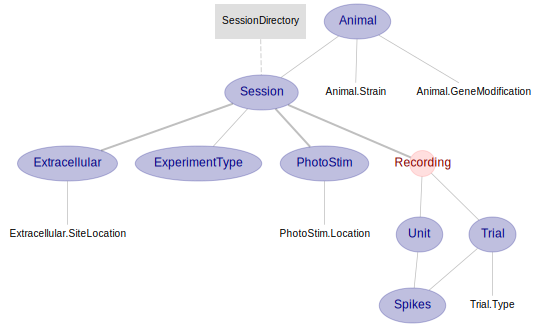

In [35]:
dj.ERD(schema)

# Plot results

In [36]:
# pick a dataset
keys = list((Recording() & Spikes()).fetch.keys())
key = keys[30]

Populating the interactive namespace from numpy and matplotlib
OrderedDict([('animal', 218457), ('session', 6)])


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Hits: left 49 right 39 Units:  20
....................

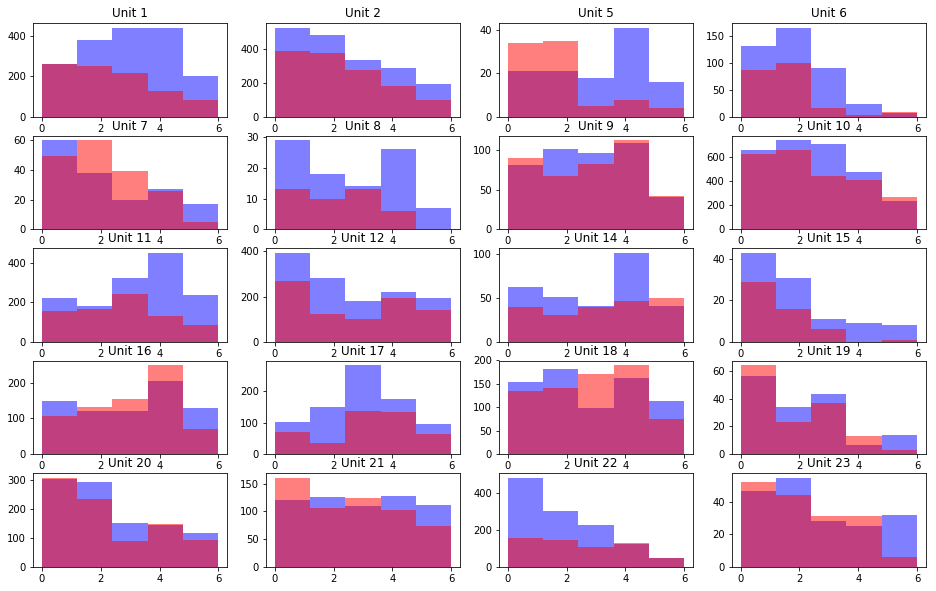

In [37]:
%pylab inline
# plot PSTHs of left (blue) vs right (red) trials
print(key)
good_trials = (Trial() & key & 'good_trial') - (Trial.Type() & 'trial_type in ("LickEarly", "StimTrials")')
left_trials = good_trials & (Trial.Type() & 'trial_type in ("HitL")')
right_trials = good_trials & (Trial.Type() & 'trial_type in ("HitR")')
n_units = len(Unit() & key)
print('Hits: left', len(left_trials), 'right', len(right_trials), 'Units: ', n_units)

ncols = 4
nrows = (n_units + ncols - 1)//ncols
rcParams['figure.figsize'] = (16, 10)

_, ax = plt.subplots(nrows, ncols)
ax  = ax.flatten()
bins = np.linspace(0,6,6)
x = (bins[:-1]+bins[1:])/2
for i, unit_key in enumerate((Unit() & key).fetch.keys()):
    print(end='.')
    left = (Trial()*Spikes() & unit_key & left_trials).fetch('start_time', 'spike_times')
    if left[0].size:
        left = np.concatenate([spikes-start for start, spikes in zip(*left)])
        ax[i].hist(left, bins, color='blue', alpha=0.5)
    right = (Trial()*Spikes() & unit_key & right_trials).fetch('start_time', 'spike_times')
    if right[0].size:
        right = np.concatenate([spikes-start for start, spikes in zip(*right)])
        ax[i].hist(right, bins, color='red', alpha=0.5)
    ax[i].set_title('Unit {unit}'.format(**unit_key))

# clear unused axes
for i in range(n_units,ncols*nrows):
    ax[i].axis('off')
